# <u> Data Cleaning </u>

The purpose of this notebook is to perform all necessary data cleaning, feature engineering, and dataset preparation steps based on the exploratory data analysis conducted in the previous notebook (`01_eda.ipynb`).

## <u> 0. Import libraries and dataframes:</u>

In [4]:
# Import libraries
import pandas as pd
import numpy as np, os, sys, matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import MultiLabelBinarizer

# Set repository directory
current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from modules.data_cleaning import *
from modules.data_analysis import data_quality_summary

In [5]:
# Import dataframe
ratings_df = pd.read_csv('../data/raw/ratings.csv', parse_dates=["timestamp"])
movies_df = pd.read_csv('../data/raw/movies.csv')
genome_scores_df = pd.read_csv('../data/raw/genome_scores.csv')
genome_tags_df = pd.read_csv('../data/raw/genome_tags.csv')

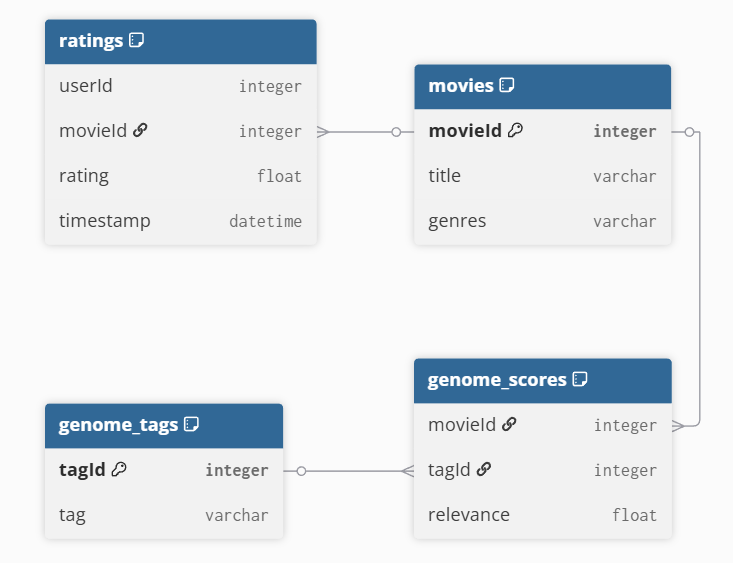

In [6]:
Image(filename='images/diagram_schema.png', width=650) 

## <u>1. Dataset Reduction and Alignment </u>

As a first step in the cleaning process, we reduce `ratings.csv` by randomly sampling 6,000 distinct users. We then filter to ensure that each movie has at least 10 reviews. Because this reduction also affects the minimum number of reviews per user (which must remain above 20), these two filtering steps are iterated until convergence to satisfy both conditions. This iterative process naturally decreases the total number of distinct users from the initial 6,000, but given the large size of the dataset, this reduction is acceptable to maintain data quality without significantly prolonging convergence.

In [8]:
# First we filter based on number of distincted users wanted
rating_df_adj = sample_users(ratings_df, n_users=6000, random_state=12)

# Iteratively adjust rating_df_adj based on condition of minimum number of review
rating_df_adj, _ = iterative_filter(rating_df_adj, min_user_ratings=20, min_movie_ratings=10, max_iter=10)

# Find resulting valid movies
valid_movies = rating_df_adj['movieId'].unique()
movies_df_adj = movies_df[movies_df['movieId'].isin(valid_movies)].copy()

# Save cleaned datasets
rating_df_adj.to_csv("../data/processed/ratings.csv", index=False)
movies_df_adj.to_csv("../data/processed/movies.csv", index=False)

As a second step, we filter `genome_scores.csv` to retain only the movies that survived the initial cleaning of the ratings dataset, ensuring consistency across all tables. In contrast, `the genome_tags` dataframe does not require any adjustment, since the tags themselves are reference data and are not affected by the previous filtering.

In [9]:
# Filter rows in genome_scores_df based on remaining movieIds
remaining_movieIds = rating_df_adj['movieId'].unique()
genome_scores_df_adj = genome_scores_df[genome_scores_df['movieId'].isin(remaining_movieIds)].copy()

# Save cleaned datasets
genome_scores_df_adj.to_csv("../data/processed/genome_scores.csv", index=False)
genome_tags_df.to_csv("../data/processed/genome_tags.csv", index=False)

In [7]:
# Load cleaned datasets
rating_df = pd.read_csv("../data/processed/ratings.csv")
movie_df = pd.read_csv("../data/processed/movies.csv")
genome_scores_df = pd.read_csv("../data/processed/genome_scores.csv")
genome_tags_df = pd.read_csv("../data/processed/genome_tags.csv")

In [8]:
# Compare file sizes before and after cleaning
raw_ratings_size = os.path.getsize('../data/raw/ratings.csv') / (1024 * 1024)
processed_ratings_size = os.path.getsize('../data/processed/ratings.csv') / (1024 * 1024)
raw_movies_size = os.path.getsize('../data/raw/movies.csv') / (1024 * 1024)
processed_movies_size = os.path.getsize('../data/processed/movies.csv') / (1024 * 1024)
raw_genome_scores_size = os.path.getsize('../data/raw/genome_scores.csv') / (1024 * 1024)
processed_genome_scores_size = os.path.getsize('../data/processed/genome_scores.csv') / (1024 * 1024)
raw_genome_tags_size = os.path.getsize('../data/raw/genome_tags.csv') / (1024 * 1024)
processed_genome_tags_size = os.path.getsize('../data/processed/genome_tags.csv') / (1024 * 1024)

# Print file size comparison
print(f"\nRatings file size reduced from {raw_ratings_size:.2f} MB to {processed_ratings_size:.2f} MB")
print(f"Movies file size reduced from {raw_movies_size:.2f} MB to {processed_movies_size:.2f} MB")
print(f"Genome Scores file size reduced from {raw_genome_scores_size:.2f} MB to {processed_genome_scores_size:.2f} MB")
print(f"Genome Tags file size remains the same at {raw_genome_tags_size:.2f} MB\n")


Ratings file size reduced from 658.37 MB to 29.18 MB
Movies file size reduced from 1.42 MB to 0.31 MB
Genome Scores file size reduced from 204.39 MB to 124.86 MB
Genome Tags file size remains the same at 0.02 MB



## <u>2. Datasets Check </u>

In [9]:
_ = data_quality_summary(rating_df, "Cleaned Ratings Data Quality Summary")


DATA QUALITY REPORT: Cleaned Ratings Data Quality Summary

BASIC INFO:
  Rows: 850,111
  Columns: 4
  Memory Usage: 81.07 MB

 COLUMN SUMMARY:
              Type  Non-Null  Null  Null %  Unique  Unique %
userId       int64    850111     0     0.0    5976      0.70
movieId      int64    850111     0     0.0    6568      0.77
rating     float64    850111     0     0.0      10      0.00
timestamp   object    850111     0     0.0  670794     78.91

 DUPLICATES:
  Total duplicate rows: 0 (0.00%)




In [10]:
_ = data_quality_summary(movie_df, "Cleaned Movies Data Quality Summary")


DATA QUALITY REPORT: Cleaned Movies Data Quality Summary

BASIC INFO:
  Rows: 6,568
  Columns: 3
  Memory Usage: 1.03 MB

 COLUMN SUMMARY:
           Type  Non-Null  Null  Null %  Unique  Unique %
movieId   int64      6568     0     0.0    6568    100.00
title    object      6568     0     0.0    6567     99.98
genres   object      6568     0     0.0     788     12.00

 DUPLICATES:
  Total duplicate rows: 0 (0.00%)




In [11]:
_ = data_quality_summary(genome_scores_df, "Cleaned Genome Scores Data Quality Summary")


DATA QUALITY REPORT: Cleaned Genome Scores Data Quality Summary

BASIC INFO:
  Rows: 7,369,224
  Columns: 3
  Memory Usage: 168.67 MB

 COLUMN SUMMARY:
              Type  Non-Null  Null  Null %  Unique  Unique %
movieId      int64   7369224     0     0.0    6533      0.09
tagId        int64   7369224     0     0.0    1128      0.02
relevance  float64   7369224     0     0.0    3999      0.05

 DUPLICATES:
  Total duplicate rows: 0 (0.00%)


